# Data Import Using GAIA Query

### Field star region selection.

https://www.aanda.org/articles/aa/abs/2019/04/aa34337-18/aa34337-18.html

From here we will take a region on the sky with b=-35,l=160, we expect reddening increase around 400pc as per the paper above.

See Fig 5 (a).

## Reddening Vectors:

reddening vector in 2mass:
The resultant ratios are AKS /EH −KS = 1.46 ± 0.03 and AKS /EJ −KS = 0.499 ± 0.018, quite consistent with the previously derived ratios 1.44 ± 0.01, 0.494 ± 0.006 in Nishiyama et al. (2006). Therefore, the use of RGB colors does not affect the results.
https://iopscience.iop.org/article/10.1088/0004-637X/696/2/1407/pdf

https://gea.esac.esa.int/archive/documentation/GDR2/Data_analysis/chap_cu8par/sec_cu8par_process/ssec_cu8par_process_priamextinction.html

Above talks about the different redenning vectors for Gaia and how it does depend on the different temperatuere of stars but for relatively hot stars the Ag=2E works ok.

Look also at https://arxiv.org/pdf/1008.0815.pdf

Need to consider different stars.

# DATA

In [1]:
%matplotlib inline

4 degree circle now!

In [2]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import os
import torch
if('High_latitude_sample' in os.getcwd()):
    os.chdir('../')
from star_sample import StarSample, Isochrones



'''

job4 = Gaia.launch_job_async("SELECT * \
FROM gaiadr3.gaia_source AS g, gaiadr3.astrophysical_parameters AS p, gaiaedr3_distance as d \
WHERE g.source_id = p.source_id \
AND g.source_id=d.source_id \
AND CONTAINS(POINT(g.l,g.b),CIRCLE(160.0,-35.0,4))=1;", dump_to_file=False)


r = job4.get_results()
'''

'\n\njob4 = Gaia.launch_job_async("SELECT * FROM gaiadr3.gaia_source AS g, gaiadr3.astrophysical_parameters AS p, gaiaedr3_distance as d WHERE g.source_id = p.source_id AND g.source_id=d.source_id AND CONTAINS(POINT(g.l,g.b),CIRCLE(160.0,-35.0,4))=1;", dump_to_file=False)\n\n\nr = job4.get_results()\n'

In [3]:
'''
job4 = Gaia.launch_job_async("SELECT * \
FROM gaiadr3.gaia_source AS g \
JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch USING (source_id) \
JOIN gaiadr3.tmass_psc_xsc_join AS xjoin USING (clean_tmass_psc_xsc_oid) \
JOIN gaiadr1.tmass_original_valid AS tmass ON xjoin.original_psc_source_id = tmass.designation \
WHERE CONTAINS(POINT(g.l,g.b),CIRCLE(160.0,-35.0,4))=1;", dump_to_file=False)


r2MASS = job4.get_results()

'''

'\njob4 = Gaia.launch_job_async("SELECT * FROM gaiadr3.gaia_source AS g JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch USING (source_id) JOIN gaiadr3.tmass_psc_xsc_join AS xjoin USING (clean_tmass_psc_xsc_oid) JOIN gaiadr1.tmass_original_valid AS tmass ON xjoin.original_psc_source_id = tmass.designation WHERE CONTAINS(POINT(g.l,g.b),CIRCLE(160.0,-35.0,4))=1;", dump_to_file=False)\n\n\nr2MASS = job4.get_results()\n\n'

We need some prior on the distance but for now we wil just use the parallax.

In [4]:
import pandas as pd
#r=r.to_pandas().set_index('source_id').combine_first(r2MASS.to_pandas().set_index('source_id')).reset_index()

In [5]:
os.chdir('Data')

In [6]:
r=pd.read_csv('input_data')
os.chdir('..')

/var/folders/v8/qszwt8g90wj00vpb5s08vpdw0000gn/T/ipykernel_9117/3821054705.py:1: DtypeWarning: Columns (67) have mixed types. Specify dtype option on import or set low_memory=False.
  r=pd.read_csv('input_data')


### Parallax error

As per Bailer Jones, prior needed for about 20 percent error on parallax, which amounts to 40% of the stars along the line of sight.

In [7]:
r['error_over_parallax']=1/r['parallax_over_error']
(r['error_over_parallax']<0.2).sum()/len(r)

0.4511329555036129

In [8]:
#r=r[r['error_over_parallax']<0.4]
#r=r[r['error_over_parallax']>-0.4]

In [9]:
r['pdist']=1/r['parallax']


In [10]:
r

,Unnamed: 0,source_id,DESIGNATION,abp_gspphot,abp_gspphot_lower,abp_gspphot_upper,activityindex_espcs,activityindex_espcs_input,activityindex_espcs_uncertainty,ag_esphs,...,vsini_esphs,vsini_esphs_uncertainty,xm_flag,zrfe_gspspec,zrfe_gspspec_linescatter,zrfe_gspspec_lower,zrfe_gspspec_nlines,zrfe_gspspec_upper,error_over_parallax,pdist
0,0,30810308675720704,Gaia DR3 30810308675720704,0.2938,0.2293,0.3611,NaN,NaN,NaN,NaN,...,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,0.145924,0.536473
1,1,30810416049701376,Gaia DR3 30810416049701376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.997409,-0.824427
2,2,30810446114675584,Gaia DR3 30810446114675584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,0.266595,0.636656
3,3,30810450409367424,Gaia DR3 30810450409367424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.091845,0.805832
4,4,30810450409676800,Gaia DR3 30810450409676800,0.4378,0.3762,0.5510,NaN,NaN,NaN,NaN,...,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,0.337704,3.508053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187381,187381,112601024455479168,Gaia DR3 112601024455479168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.032466,-1.088745
187382,187382,112601054520355456,Gaia DR3 112601054520355456,0.7972,0.7887,0.8067,NaN,M2,NaN,NaN,...,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,0.024183,0.859262
187383,187383,112601058815777536,Gaia DR3 112601058815777536,0.1150,0.1042,0.1292,-0.00039,M2,0.001062,NaN,...,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,0.005849,0.260279
187384,187384,112601123239734784,Gaia DR3 112601123239734784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,0.152861,0.421741


# Distance Distribution

Seems to be plenty of stars in front and behind of the expected cloud at 400pc. Distance in plot is in kpc.

In [11]:
len(r[r['r_med_geo']<1000])

67174

Text(0.5, 1.0, 'Distribution of stars with distance')

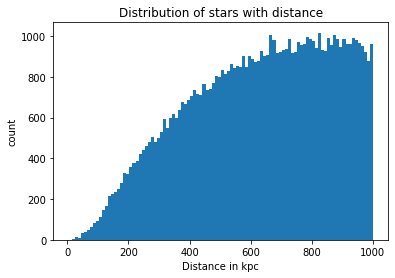

In [12]:
plt.hist(r[r['r_med_geo']<1000]['r_med_geo'],bins=100)
plt.xlabel('Distance in kpc')
plt.ylabel('count')
plt.title('Distribution of stars with distance')

### Ag GSP-Phot value distributions.

Text(0.5, 1.0, 'Extinction count')

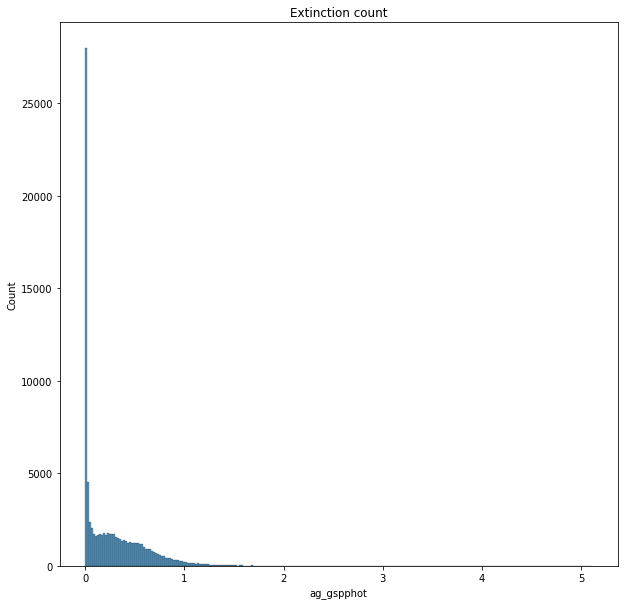

In [13]:
plt.figure(figsize=(10,10))
sn.histplot(r['ag_gspphot'])
#plt.xlim(0,2)
plt.title('Extinction count')

### Distribution of Ag from GSP-Phot over the sky, with no cuts.

/opt/homebrew/Caskroom/miniforge/base/envs/astro/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Extinction vs Distance')

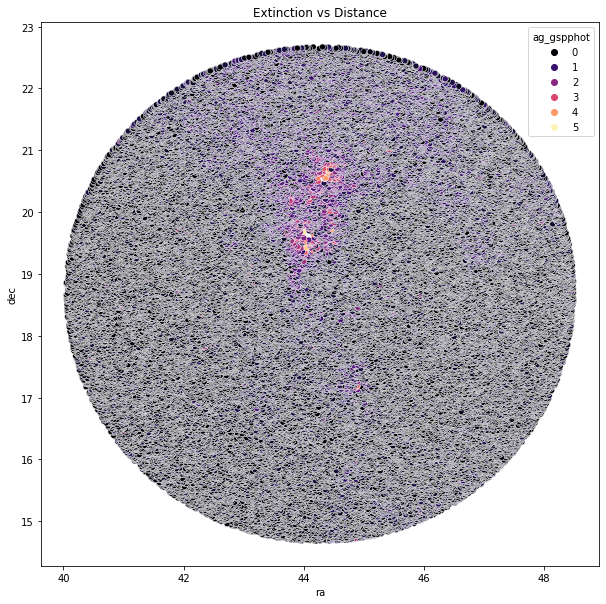

In [14]:
plt.figure(figsize=(10,10))
sn.scatterplot(r['ra'],r['dec'],hue=r['ag_gspphot'],color='r',s=35,palette='magma')
#plt.xlim(0,2)
plt.title('Extinction vs Distance')

### Distribution of Ag GSP-Phot over distance, no cuts.

/opt/homebrew/Caskroom/miniforge/base/envs/astro/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Extinction vs Distance')

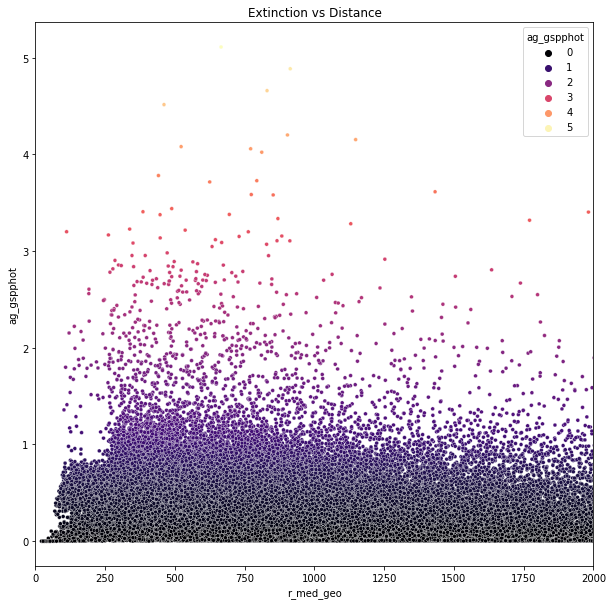

In [15]:
plt.figure(figsize=(10,10))
sn.scatterplot(r['r_med_geo'],r['ag_gspphot'],hue=r['ag_gspphot'],palette='magma',s=15)
plt.xlim(0,2000)
plt.title('Extinction vs Distance')

In [16]:
len(r)

187386

In [17]:
r['teff_gspphot']

0         3331.0240
1               NaN
2               NaN
3               NaN
4         4962.0303
            ...    
187381          NaN
187382    5725.5884
187383    6025.2285
187384          NaN
187385          NaN
Name: teff_gspphot, Length: 187386, dtype: float64

In [18]:
high_lat=r
high_lat=high_lat.reset_index(drop=True)
high_lat=high_lat.dropna(axis=0,subset=['teff_gspphot']).reset_index(drop=True)

# Percentage of points with TEFF values.

In [19]:
len(high_lat)/len(r)

0.47373869979614275

### Only 47 percent. This is problem for later. We will need to figure out how to deal with these with no values.

/opt/homebrew/Caskroom/miniforge/base/envs/astro/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Extinction vs Distance')

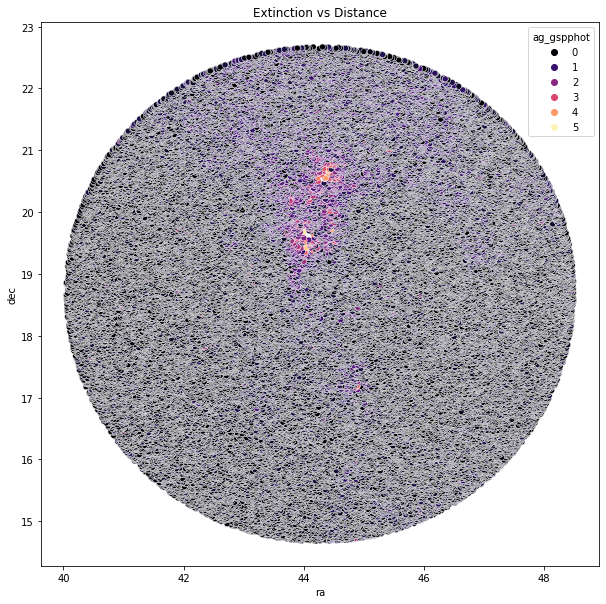

In [30]:
plt.figure(figsize=(10,10))
sn.scatterplot(high_lat['ra'],high_lat['dec'],hue=high_lat['ag_gspphot'],color='r',s=35,palette='magma')
#plt.xlim(0,2)
plt.title('Extinction vs Distance')

In [31]:
high_lat.shape

(88772, 413)

# Star_sample creation

In [32]:
import gdr3apcal



calib = gdr3apcal.GaiaDR3_GSPPhot_cal()
# Apply calibrations to [M/H] and/or Teff, returning a numpy array of calibrated values.
metal_calib = calib.calibrateMetallicity(high_lat)

Automatically adding "cos(b)" from "b" [assuming degrees].
Automatically adding "cos(b)" from "b" [assuming degrees].
Automatically adding "cos(b)" from "b" [assuming degrees].
Automatically adding "cos(b)" from "b" [assuming degrees].


In [33]:
high_lat['feh_calib']=metal_calib

In [34]:
high_lat['feh_spec']=high_lat['fem_gspspec']+high_lat['mh_gspspec']

# No cuts so far, only the ones from having a solution.

In [35]:





high_lat=high_lat[['ra','dec','parallax','phot_g_mean_mag','phot_g_mean_flux','phot_rp_mean_flux','phot_bp_mean_flux',
                       'phot_bp_mean_mag','phot_rp_mean_mag','bp_rp','ra_error','dec_error',
                       'parallax_error','phot_g_mean_flux_error','phot_bp_mean_flux_error',
                       'phot_rp_mean_flux_error','mh_gspphot','logg_gspphot','ag_gspphot','r_med_geo','j_m','h_m','ks_m','j_msigcom','h_msigcom','ks_msigcom','ruwe','feh_calib','feh_spec','teff_gspphot']].reset_index(drop=True)

features=[['ra','dec','parallax','phot_g_mean_mag','bp_rp','j_m','h_m','k_m']]
errors=[['ra_error','dec_error','parallax_error','phot_g_mean_mag_error','bp_rp_error','j_msigcom','h_msigcom','ks_msigcom']]

<AxesSubplot:xlabel='ebpminrp_gspphot', ylabel='ag_gspphot'>

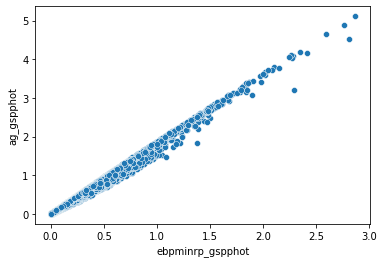

In [36]:
sn.scatterplot(data=r,x='ebpminrp_gspphot',y='ag_gspphot')

In [37]:

high_lat=StarSample(high_lat,features,errors,twomass=True)


# Isochrones

In [38]:
filters = ["Gaia_G_EDR3", "Gaia_BP_EDR3", 'Gaia_RP_EDR3','2MASS_J','2MASS_KS','2MASS_H']
massgrid = 10*np.linspace(np.log10(0.1),np.log10(10), 2000)
logagegrid = np.linspace(9.0,10.0,2)
fehgrid = np.linspace(-4.0,0.5,110)
isocs=Isochrones(filters,logagegrid,massgrid,fehgrid,override=1.77,override2=0.499)

/opt/homebrew/Caskroom/miniforge/base/envs/astro/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


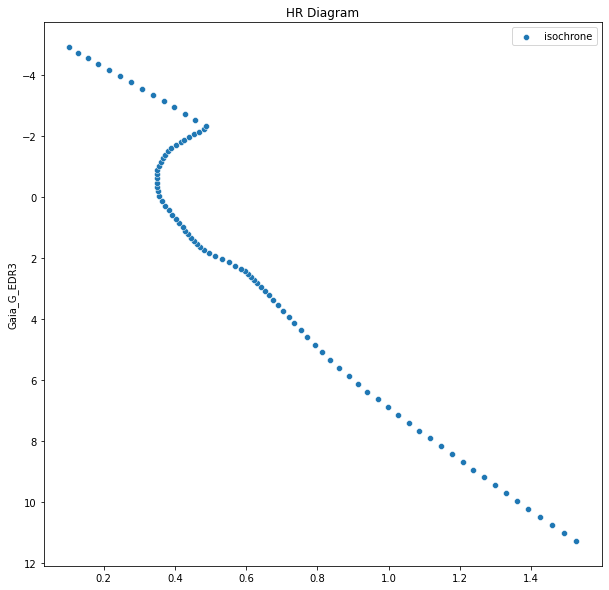

In [39]:
isochrone=isocs.isochrones_list[0]

title='HR Diagram'
mag_column='G'
colour_column='bp_rp'
hue_column='r_med_geo'
height=10
width=10
f, axes = plt.subplots(1, 1)
f.set_figheight(height)
f.set_figwidth(width)
sn.scatterplot(isochrone['Gaia_BP_EDR3']-isochrone['Gaia_RP_EDR3'], isochrone['Gaia_G_EDR3'],label='isochrone'
                                )



axes.invert_yaxis()
plt.legend()
axes.set_title(title)
plt.show()

# Pickle save

In [40]:
os.getcwd()

'/Users/mattocallaghan/VaeStar'

In [46]:
import pickle
os.chdir("Data")

output=open('isochrones_high_lat.pkl','wb') #convert to a dataframe
pickle.dump(isocs,output) #save to file



In [49]:
output=open('high_lat_values.pkl','wb') #convert to a dataframe
pickle.dump(high_lat,output)#save to file
os.chdir('..')

In [34]:
high_lat=high_lat[high_lat['r_med_geo']<1000]

# Logg is what is cutting things off.

/opt/homebrew/Caskroom/miniforge/base/envs/astro/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Extinction vs Distance')

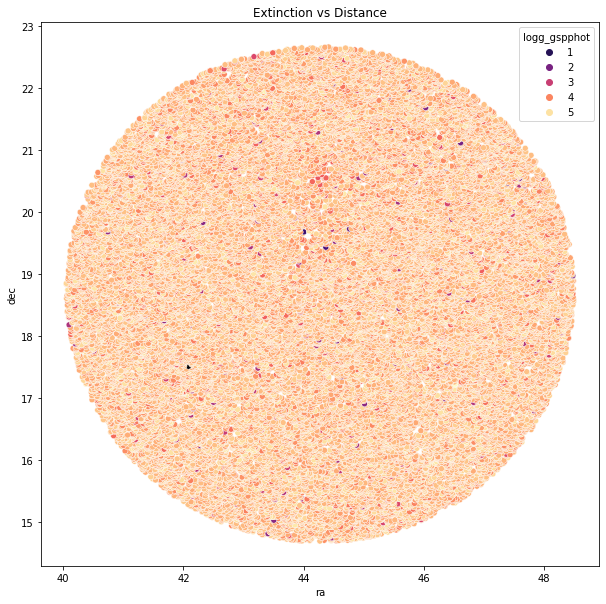

In [36]:
plt.figure(figsize=(10,10))
sn.scatterplot(high_lat['ra'],high_lat['dec'],hue=high_lat['logg_gspphot'],color='r',s=35,palette='magma')
#plt.xlim(0,2)
plt.title('Extinction vs Distance')